In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

In [2]:
num_classes = 10

learning_rate = 0.001
epochs = 100
batch_size = 128
display_step = 10

In [3]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [4]:
def run_optimization(x, y, model, optimizer):
    with tf.GradientTape() as g:
        pred = model(x, is_training=True)
        loss = cross_entropy_loss(pred, y)
        
    trainable_variables = model.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, 28*28]), x_test.reshape([-1, 28*28])
x_train, x_test = x_train / 255., x_test / 255.

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

#### FFNN

In [7]:
fc_neurons = 128

In [8]:
class FeedForward(Model):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc = layers.Dense(fc_neurons, activation=tf.nn.relu)
        self.out = layers.Dense(num_classes)

    def call(self, x, is_training=False):
        x = self.fc(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

ffnn = FeedForward()

In [9]:
optimizer = tf.optimizers.Adam(learning_rate)

ffnn_losses = []
ffnn_accs = []
for epoch, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
    run_optimization(batch_x, batch_y, ffnn, optimizer)
    
    pred = ffnn(batch_x)
    loss = cross_entropy_loss(pred, batch_y)
    acc = accuracy(pred, batch_y)
    ffnn_losses.append(loss)
    ffnn_accs.append(acc)

    if epoch % display_step == 0:
        print("epoch: %i, loss: %f, accuracy: %f" % (epoch, loss, acc))

epoch: 10, loss: 2.124130, accuracy: 0.742188
epoch: 20, loss: 1.938165, accuracy: 0.828125
epoch: 30, loss: 1.836777, accuracy: 0.843750
epoch: 40, loss: 1.736126, accuracy: 0.898438
epoch: 50, loss: 1.696649, accuracy: 0.875000
epoch: 60, loss: 1.663903, accuracy: 0.898438
epoch: 70, loss: 1.661983, accuracy: 0.906250
epoch: 80, loss: 1.678751, accuracy: 0.867188
epoch: 90, loss: 1.654318, accuracy: 0.890625
epoch: 100, loss: 1.631626, accuracy: 0.906250


In [10]:
pred = ffnn(x_test)
ffnn_test_acc = accuracy(pred, y_test)
ffnn_test_loss= cross_entropy_loss(pred, y_test)
print("Test Accuracy: %f" % ffnn_test_acc)
print("Test Loss: %f" % ffnn_test_loss)

Test Accuracy: 0.905100
Test Loss: 1.638578


#### CNN

In [11]:
conv_filters = 32
maxpool = 2
fc_neurons = 128

In [12]:
class ConvNet(Model):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = layers.Conv2D(conv_filters, kernel_size=3, activation=tf.nn.relu)
        self.maxpool1 = layers.MaxPool2D(maxpool)

        self.flatten = layers.Flatten()

        self.fc = layers.Dense(fc_neurons, activation=tf.nn.relu)
        self.out = layers.Dense(num_classes, activation=tf.nn.softmax)

    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

conv_net = ConvNet()

In [13]:
optimizer = tf.optimizers.Adam(learning_rate)

cnn_losses = []
cnn_accs = []
for epoch, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
    run_optimization(batch_x, batch_y, conv_net, optimizer)

    pred = conv_net(batch_x)
    loss = cross_entropy_loss(pred, batch_y)
    acc = accuracy(pred, batch_y)
    cnn_losses.append(loss)
    cnn_accs.append(acc)

    if epoch % display_step == 0:
        print("epoch: %i, loss: %f, accuracy: %f" % (epoch, loss, acc))

epoch: 10, loss: 2.258931, accuracy: 0.648438
epoch: 20, loss: 2.218710, accuracy: 0.796875
epoch: 30, loss: 2.207481, accuracy: 0.804688
epoch: 40, loss: 2.200386, accuracy: 0.851562
epoch: 50, loss: 2.191120, accuracy: 0.898438
epoch: 60, loss: 2.187818, accuracy: 0.921875
epoch: 70, loss: 2.188144, accuracy: 0.929688
epoch: 80, loss: 2.190789, accuracy: 0.890625
epoch: 90, loss: 2.185972, accuracy: 0.937500
epoch: 100, loss: 2.184358, accuracy: 0.937500


In [14]:
pred = conv_net(x_test)
cnn_test_acc = accuracy(pred, y_test)
cnn_test_loss = cross_entropy_loss(pred, y_test)

print("Test Accuracy: %f" % cnn_test_acc)
print("Test Loss: %f" % cnn_test_loss)

Test Accuracy: 0.915400
Test Loss: 2.187354


#### შედარება

In [15]:
df = pd.DataFrame([
    [ffnn_losses[-1], ffnn_accs[-1], ffnn_test_loss, ffnn_test_acc], 
    [cnn_losses[-1], cnn_accs[-1], cnn_test_loss, cnn_test_acc]
], columns=["train loss", "train accuracy", "test loss", "test accuracy"], dtype=float, index=["FFNN", "CNN"])
df

,train loss,train accuracy,test loss,test accuracy
FFNN,1.631626,0.90625,1.638578,0.9051
CNN,2.184358,0.93750,2.187354,0.9154


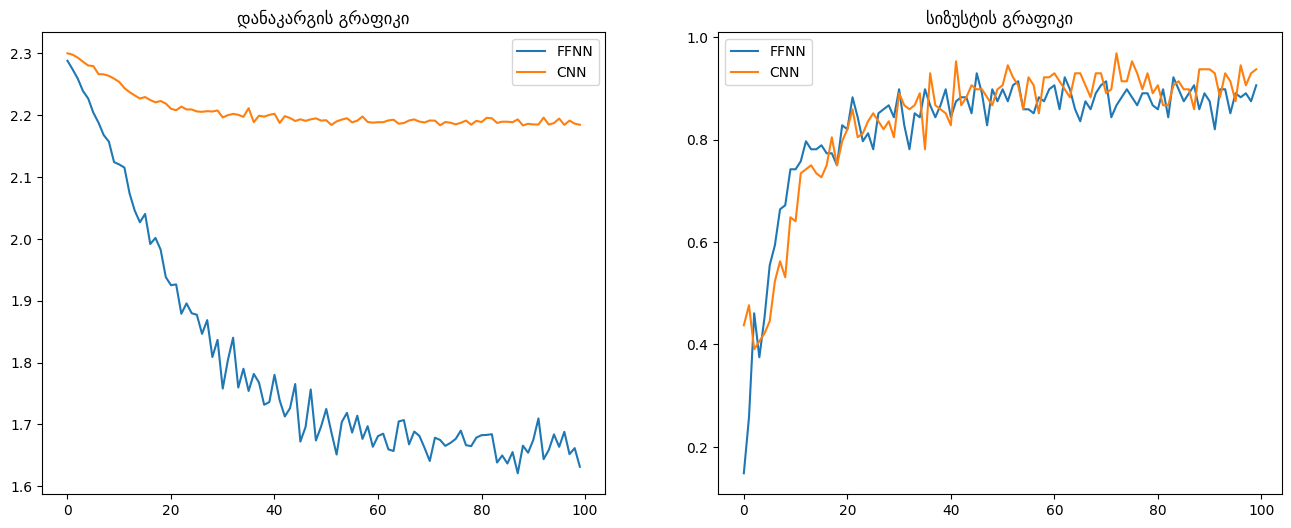

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(ffnn_losses, label = "FFNN")
ax1.plot(cnn_losses, label = "CNN")
ax1.legend()
ax1.set_title("დანაკარგის გრაფიკი")

ax2.plot(ffnn_accs, label = "FFNN")
ax2.plot(cnn_accs, label = "CNN")
ax2.legend()
ax2.set_title("სიზუსტის გრაფიკი")
plt.show()